### Pip Installs

In [1]:
!pip install datasets
!pip install pytorch_lightning
!pip install optuna
!pip install wikidata

  Using cached pytorch_lightning-2.5.1.post0-py3-none-any.whl.metadata (20 kB)
  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached pytorch_lightning-2.5.1.post0-py3-none-any.whl (823 kB)
Using cached lightning_utilities-0.14.3-py3-none-any.whl (28 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB

### Imports

In [2]:
import torch
from datasets import load_dataset
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
import sys
import glob
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from pytorch_lightning.utilities.model_summary import ModelSummary

### Import from Drive **see README.txt for more info**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Gradient_Explorers_shared_folder/scripts'
path_test_csv = '/content/drive/MyDrive/Gradient_Explorers_shared_folder/test_unlabeled.csv'
sys.path.append(path)

from modify_dataset import prepare_dataset
from my_model import claimClass
from dataloader import create_dataloader


Mounted at /content/drive


### Load the dataset

In [4]:
from huggingface_hub import login
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

In [5]:
dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')
dataset_val = dataset['validation'].to_pandas()
dataset_train = dataset['train'].to_pandas()
dataset_test = pd.read_csv(path_test_csv)
if 'label' not in dataset_test.columns:
    dataset_test['label'] = 0

README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

### hyperparameter setup , The ones in these lists are the best one found

In [6]:
MIN_WORD_FREQUENCY = [2]
FILE_CACHE_TRAIN = '/content/drive/MyDrive/Gradient_Explorers_shared_folder/datasets_expanded/all_properties.csv'
FILE_CACHE_VAL = '/content/drive/MyDrive/Gradient_Explorers_shared_folder/datasets_expanded/all_properties_val.csv'
FILE_CACHE_TEST = '/content/drive/MyDrive/Gradient_Explorers_shared_folder/datasets_expanded/all_properties_test.csv'
EMBEDDING_DIM = [128]
MODE = ["mean"]
LEARNING_RATE = [1e-4]
BATCH_SIZE = [64]
EPOCHS = 100
NUM_WORKERS = 4
NUM_CLASSES = 3
DROPOUT = [0.3]
# True if you want to train the model
TRAIN_MODEL = False

### Function to train the model with optuna , it will perform a quick Grid Search to find the best hyperparameters as well as give us the best weights

In [7]:
def objective(trial):
    """
    function to optimize hyperparameters using Optuna
    """
    embedding_dim = trial.suggest_categorical("embedding_dim", EMBEDDING_DIM)
    lr = trial.suggest_categorical("lr", LEARNING_RATE)
    dropout = trial.suggest_categorical("dropout", DROPOUT)
    batch_size = trial.suggest_categorical("batch_size", BATCH_SIZE)
    min_word_freq = trial.suggest_categorical("min_word_freq", MIN_WORD_FREQUENCY)
    mode = trial.suggest_categorical("mode", MODE)

    vocab_size_p, word_to_idx_p, vocab_size_q, word_to_idx_q, dataset_train_mod, unk_label = prepare_dataset(dataset_train, FILE_CACHE_TRAIN, min_word_frequency=min_word_freq)
    _, _, _, _, dataset_val_mod, _ = prepare_dataset(dataset_val, FILE_CACHE_VAL, is_train=False, word_to_idx_p=word_to_idx_p, word_to_idx_q=word_to_idx_q, unk_label=unk_label)

    train_loader = create_dataloader(dataset_train_mod, batch_size, NUM_WORKERS)
    val_loader = create_dataloader(dataset_val_mod, batch_size, NUM_WORKERS, shuffle=False)

    checkpoint_callback = ModelCheckpoint(
        dirpath=f"checkpoints/trial_{trial.number}/",
        filename='best-model-{epoch:02d}-{validation_f1_score:.2f}',
        save_top_k=1,
        monitor='validation_f1_score',
        mode='max',
        save_last=True
    )

    early_stopping_callback = EarlyStopping(
        monitor='validation_f1_score',
        patience=10,
        verbose=True,
        mode='max'
    )

    model = claimClass(
        vocab_size_s= vocab_size_p,
        vocab_size_c= vocab_size_q,
        embedding_dim=embedding_dim,
        num_classes=NUM_CLASSES,
        mode=mode,
        le=lr,
        batch_size=batch_size,
        dropout=dropout,
    )

    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        callbacks=[checkpoint_callback, early_stopping_callback],
        accelerator="gpu" if torch.cuda.is_available() else "cpu"
    )

    trainer.fit(model, train_loader, val_loader)

    best_score = checkpoint_callback.best_model_score
    print(f"Trial n. {trial.number} terminated, the best F1 score Loss is: {best_score.item()}")

    return best_score.item()

### if TRAIN_MODEL is true train the model with optuna, otherwise it will load the local weights

In [8]:
if TRAIN_MODEL:
  study = optuna.create_study(direction="maximize", sampler=optuna.samplers.GridSampler({
      "embedding_dim": EMBEDDING_DIM,
      "lr": LEARNING_RATE,
      "batch_size": BATCH_SIZE,
      "dropout": DROPOUT,
      "min_word_freq": MIN_WORD_FREQUENCY,
      "mode": MODE,
  }))

  study.optimize(objective)

  best_trial_dir = f"checkpoints/trial_{study.best_trial.number}/"

  ckpt_files = [f for f in glob.glob(f"{best_trial_dir}/*.ckpt") if 'last.ckpt' not in f]
  if not ckpt_files:
      best_model_path = glob.glob(f"{best_trial_dir}/last.ckpt")[0]
  else:
      best_model_path = ckpt_files[0]

else:
  best_model_path = f"/content/drive/MyDrive/Gradient_Explorers_shared_folder/scripts/best-model-epoch=70-validation_f1_score=0.77.ckpt"

### Extract the best trial and load the model's weight

In [9]:
model = claimClass.load_from_checkpoint(best_model_path)
ModelSummary(model, max_depth=-1)

   | Name         | Type                | Params | Mode 
--------------------------------------------------------------
0  | embeddingS   | Embedding           | 67.2 K | train
1  | embeddingC   | Embedding           | 955 K  | train
2  | sequential   | Sequential          | 16.6 K | train
3  | sequential.0 | Linear              | 16.4 K | train
4  | sequential.1 | ReLU                | 0      | train
5  | sequential.2 | Dropout             | 0      | train
6  | sequential.3 | Linear              | 195    | train
7  | accuracy     | MulticlassAccuracy  | 0      | train
8  | precision    | MulticlassPrecision | 0      | train
9  | recall       | MulticlassRecall    | 0      | train
10 | f1_score     | MulticlassF1Score   | 0      | train
11 | criterion    | CrossEntropyLoss    | 0      | train
--------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.158     Total estimated model params size (MB)
12 

### Use The model in the Validation Set for evaluation

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluating Validation Set:   0%|          | 0/5 [00:00<?, ?it/s]

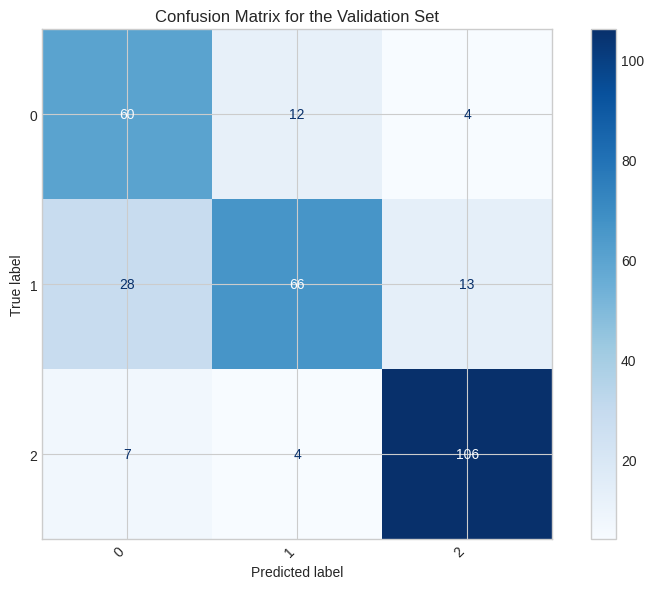


Normalized Confusion Matrix (row-wise %):


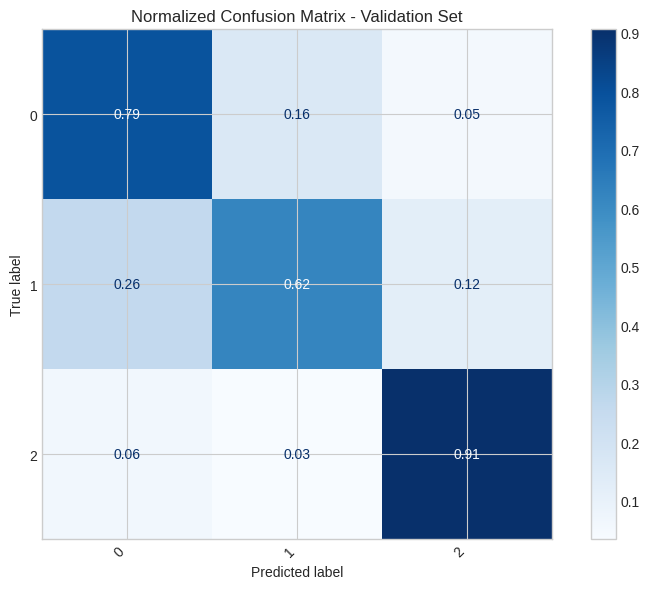

Accuracy:           0.7733
------------------------------
Precision (Macro):  0.7661
Recall (Macro):     0.7708
F1 Score (Macro):   0.7612
------------------------------
Precision (Weighted): 0.7832
Recall (Weighted):    0.7733
F1 Score (Weighted):  0.7714
------------------------------
Precision (Micro):  0.7733
Recall (Micro):     0.7733
F1 Score (Micro):   0.7733


In [11]:
class_names = [str(i) for i in range(NUM_CLASSES)]
num_classes = 3
# Set model to evaluation mode
model.eval()

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []

vocab_size_p, word_to_idx_p, vocab_size_q, word_to_idx_q, dataset_train_mod, unk_label = prepare_dataset(dataset_train, FILE_CACHE_TRAIN, min_word_frequency=MIN_WORD_FREQUENCY[0])
_, _, _, _, dataset_val_mod, _ = prepare_dataset(dataset_val, FILE_CACHE_VAL, is_train=False, word_to_idx_p=word_to_idx_p, word_to_idx_q=word_to_idx_q, unk_label=unk_label)

train_loader = create_dataloader(dataset_train_mod, BATCH_SIZE[0], NUM_WORKERS)
val_loader = create_dataloader(dataset_val_mod, BATCH_SIZE[0], NUM_WORKERS, shuffle=False)

# Disable gradient calculations for inference
with torch.no_grad():
    # Iterate over the validation dataloader (using the 'best' version)
    for batch in tqdm(val_loader, desc="Evaluating Validation Set"):
        statement_tensor = batch[0].to(device)
        claim_tensor = batch[1].to(device)
        offset_tensor = batch[2].to(device)
        target_tensor = batch[3].to(device)

        outputs = model(statement_tensor, claim_tensor, offset_tensor)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(target_tensor.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

plt.title(f"Confusion Matrix for the Validation Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print("\nNormalized Confusion Matrix (row-wise %):")
cm_normalized = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)), normalize='true')
cm_normalized = np.nan_to_num(cm_normalized)


fig_norm, ax_norm = plt.subplots(figsize=(8, 6))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp_norm.plot(cmap=plt.cm.Blues, ax=ax_norm, values_format=".2f", colorbar=True) # Format as float with 2 decimals
plt.title(f"Normalized Confusion Matrix - Validation Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)
recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)
f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

accuracy_overall = accuracy_score(all_labels, all_preds)

print(f"Accuracy:           {accuracy_overall:.4f}")
print("-" * 30)
print(f"Precision (Macro):  {precision_macro:.4f}")
print(f"Recall (Macro):     {recall_macro:.4f}")
print(f"F1 Score (Macro):   {f1_macro:.4f}")
print("-" * 30)
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1 Score (Weighted):  {f1_weighted:.4f}")
print("-" * 30)
print(f"Precision (Micro):  {precision_micro:.4f}")
print(f"Recall (Micro):     {recall_micro:.4f}")
print(f"F1 Score (Micro):   {f1_micro:.4f}")
print("="*30)



### Use the model for Inference on the Test Set

In [12]:
num_classes = 3
class_names = [str(i) for i in range(num_classes)]

# Set model to evaluation mode
model.eval()

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []

_, _, _, _, dataset_test_mod, _ = prepare_dataset(dataset_test, FILE_CACHE_TEST, is_train=False, word_to_idx_p=word_to_idx_p, word_to_idx_q=word_to_idx_q, unk_label=unk_label)

test_loader = create_dataloader(dataset_test_mod, BATCH_SIZE[0], NUM_WORKERS, shuffle=False)

# Disable gradient calculations for inference
with torch.no_grad():
    # Iterate over the validation dataloader (using the 'best' version)
    for batch in tqdm(test_loader):
        statement_tensor = batch[0].to(device)
        claim_tensor = batch[1].to(device)
        offset_tensor = batch[2].to(device)
        target_tensor = batch[3].to(device)

        outputs = model(statement_tensor, claim_tensor, offset_tensor)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())

all_preds = np.concatenate(all_preds)

index_to_label = {0: 'cultural exclusive', 1: 'cultural representative', 2: 'cultural agnostic'}
predicted_labels = [index_to_label[idx] for idx in all_preds]
dataset_test['label'] = predicted_labels

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
output_filename = 'submission_model_2.csv'
dataset_test.to_csv(output_filename, index=False)